# Regression Modelling

In [1]:
import numpy as np
import pandas as pd 
df = pd.read_csv("../data/COMP1801_Coursework_Dataset_Corrected.csv")
df.shape
df.head()

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,1107.81,Valve,singleGrain,27,2.64,8.08,23.35,60.65,19.76,15.18,4.41,7,0,0,Top,Investment
1,1226.13,Valve,colGrain,24,4.06,1.11,24.98,52.47,31.63,12.32,3.58,30,1,0,Top,Continuous
2,1914.12,Blade,singleGrain,20,4.36,8.54,34.71,60.98,26.56,11.60,0.86,22,0,0,Bottom,Continuous
3,1240.83,Valve,singleGrain,14,3.59,8.83,21.61,54.13,26.71,17.81,1.35,10,0,0,Bottom,Continuous
4,1599.40,Nozzle,singleGrain,22,3.06,3.04,29.65,62.88,24.06,12.08,0.98,21,0,0,Top,Investment


### Now we will split the dataset into train data and test data:

1. Train data contains **80%** of the dataset for training
2. Test data contains **20%** of the dataset purely for testing 

In [3]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Lifespan'])
y = df['Lifespan']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)
print(f"size of X_train is :{X_train.shape} and that of X_test is :{X_test.shape}")
print(f"size of y_train is :{y_train.shape} and that of y_test is :{y_test.shape}")

size of X_train is :(800, 15) and that of X_test is :(200, 15)
size of y_train is :(800,) and that of y_test is :(200,)


### Encoding features:

For encoding purpose I will choose OneHotEncoder to avoid imposing a false numerical order, which is a risk with the LabelEncoder.

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

In [15]:
# grouping numerical and categorical feature columns

cat_col = X_train.select_dtypes(include=['object','category']).columns.tolist()
num_col = X_train.select_dtypes(include=['int64','float64']).columns.tolist()

print(cat_col)
print(num_col)

['partType', 'microstructure', 'seedLocation', 'castType']
['coolingRate', 'quenchTime', 'forgeTime', 'HeatTreatTime', 'Nickel%', 'Iron%', 'Cobalt%', 'Chromium%', 'smallDefects', 'largeDefects', 'sliverDefects']


In [16]:
# create preprocessing pipelines for each data type

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd

# Create preprocessing pipelines for each data type
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('cat', categorical_transformer, cat_col)
    ],
    remainder='passthrough'
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

num_feature_names = num_col
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_col)

all_feature_names = list(num_feature_names) + list(cat_feature_names)

X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=all_feature_names, index=X_train.index)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=all_feature_names, index=X_test.index)

print(f"Original shape: {X_train.shape}")
print(f"Preprocessed shape: {X_train_preprocessed.shape}")
print(f"\nFeature names after preprocessing:\n{all_feature_names}")

Original shape: (800, 15)
Preprocessed shape: (800, 23)

Feature names after preprocessing:
['coolingRate', 'quenchTime', 'forgeTime', 'HeatTreatTime', 'Nickel%', 'Iron%', 'Cobalt%', 'Chromium%', 'smallDefects', 'largeDefects', 'sliverDefects', 'partType_Blade', 'partType_Block', 'partType_Nozzle', 'partType_Valve', 'microstructure_colGrain', 'microstructure_equiGrain', 'microstructure_singleGrain', 'seedLocation_Bottom', 'seedLocation_Top', 'castType_Continuous', 'castType_Die', 'castType_Investment']


---

### Base Modelling:

1. Now let us start with modelling our data with a baseline model that predicts mean of training data. 
2. This serves as a baseline for our final model which should outperform this dummy regressor.
3. This helps us identify if our model is learning anything at all.

In [18]:
from sklearn.dummy import DummyRegressor 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVR 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [19]:
# Baseline dummy regressor

baseline_model = DummyRegressor(strategy='mean')
baseline_model.fit(X_train_preprocessed, y_train)

y_train_baseline = baseline_model.predict(X_train_preprocessed)
y_test_baseline = baseline_model.predict(X_test_preprocessed)

baseline_train_r2 = r2_score(y_train, y_train_baseline)
baseline_test_r2 = r2_score(y_test, y_test_baseline)
baseline_test_mse = mean_squared_error(y_test, y_test_baseline)
baseline_test_mae = mean_absolute_error(y_test, y_test_baseline)

print(f"\nBaseline Model (Mean Strategy):")
print(f"  Train R²: {baseline_train_r2:.4f}")
print(f"  Test R²:  {baseline_test_r2:.4f}")
print(f"  Test MSE: {baseline_test_mse:.4f}")
print(f"  Test MAE: {baseline_test_mae:.4f}")


Baseline Model (Mean Strategy):
  Train R²: 0.0000
  Test R²:  -0.0000
  Test MSE: 113480.9922
  Test MAE: 279.3145


#### Key takeaways of baseline mode:

1. R2 score: model socres 0.0000 that means it cannot explain any variance at all since it uses 'mean' strategy
2. MSE and MAE tell us that the model is missing patterns by only predicting mean 

### Modelling with Support Vector Regressor (SVR)

In [24]:
svr_params = {
    'C': [0.1, 1, 10, 100, 150, 200],
    'kernel':['linear','rbf','poly'],
    'epsilon':[0.01, 0.1, 0.5]
}

svr_model = SVR()

svr_grid_search = GridSearchCV(
    estimator=svr_model,
    param_grid=svr_params,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("\nTraining SVR with GridSearchCV....")
svr_grid_search.fit(X_train_preprocessed, y_train)

# best SVR model
best_svr_model = svr_grid_search.best_estimator_

print(f"\nBest SVR Hyperparameters: {svr_grid_search.best_params_}")
print(f"Best CV R² Score: {svr_grid_search.best_score_:.4f}")

# Make predictions with best SVR
y_train_svr = best_svr_model.predict(X_train_preprocessed)
y_test_svr = best_svr_model.predict(X_test_preprocessed)

# Evaluate SVR
svr_train_r2 = r2_score(y_train, y_train_svr)
svr_test_r2 = r2_score(y_test, y_test_svr)
svr_test_mse = mean_squared_error(y_test, y_test_svr)
svr_test_mae = mean_absolute_error(y_test, y_test_svr)

print(f"\nSVR Performance:")
print(f"  Train R²: {svr_train_r2:.4f}")
print(f"  Test R²:  {svr_test_r2:.4f}")
print(f"  Test MSE: {svr_test_mse:.4f}")
print(f"  Test MAE: {svr_test_mae:.4f}")


Training SVR with GridSearchCV....
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best SVR Hyperparameters: {'C': 200, 'epsilon': 0.5, 'kernel': 'rbf'}
Best CV R² Score: 0.6895

SVR Performance:
  Train R²: 0.8331
  Test R²:  0.7284
  Test MSE: 30817.1237
  Test MAE: 136.5694


In [25]:
# ============================================================================
# 4b. MODEL TRAINING - GRADIENT BOOSTING REGRESSOR
# ============================================================================
print("\n" + "=" * 70)
print("4. MODEL TRAINING - GBR (Gradient Boosting Regressor)")
print("=" * 70)

# Define GBR hyperparameter grid
gbr_params = {
    'n_estimators': [50, 100, 200],           # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.5],       # Learning rate
    'max_depth': [3, 5, 7],                   # Max tree depth
    'subsample': [0.8, 1.0]                  # Subsample ratio
}

# Create GBR model
gbr_model = GradientBoostingRegressor(random_state=42)

# GridSearchCV to find best hyperparameters
gbr_grid_search = GridSearchCV(
    estimator=gbr_model,
    param_grid=gbr_params,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("\nTraining GBR with GridSearchCV...")
gbr_grid_search.fit(X_train_preprocessed, y_train)

# Get best GBR model
best_gbr_model = gbr_grid_search.best_estimator_

print(f"\nBest GBR Hyperparameters: {gbr_grid_search.best_params_}")
print(f"Best CV R² Score: {gbr_grid_search.best_score_:.4f}")

# Make predictions with best GBR
y_train_gbr = best_gbr_model.predict(X_train_preprocessed)
y_test_gbr = best_gbr_model.predict(X_test_preprocessed)

# Evaluate GBR
gbr_train_r2 = r2_score(y_train, y_train_gbr)
gbr_test_r2 = r2_score(y_test, y_test_gbr)
gbr_test_mse = mean_squared_error(y_test, y_test_gbr)
gbr_test_mae = mean_absolute_error(y_test, y_test_gbr)

print(f"\nGBR Performance:")
print(f"  Train R²: {gbr_train_r2:.4f}")
print(f"  Test R²:  {gbr_test_r2:.4f}")
print(f"  Test MSE: {gbr_test_mse:.4f}")
print(f"  Test MAE: {gbr_test_mae:.4f}")



4. MODEL TRAINING - GBR (Gradient Boosting Regressor)

Training GBR with GridSearchCV...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best GBR Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best CV R² Score: 0.9852

GBR Performance:
  Train R²: 0.9979
  Test R²:  0.9874
  Test MSE: 1432.1436
  Test MAE: 30.1800


In [35]:
import matplotlib.pyplot as plt


MODEL COMPARISON SUMMARY

           Model  Train R²   Test R²      Test MSE   Test MAE
Baseline (Mean)  0.000000 -0.000008 113480.992244 279.314484
            SVR  0.833132  0.728436  30817.123700 136.569356
            GBR  0.997910  0.987380   1432.143615  30.179950

 Best Model: GBR with Test R² = 0.9874!!!


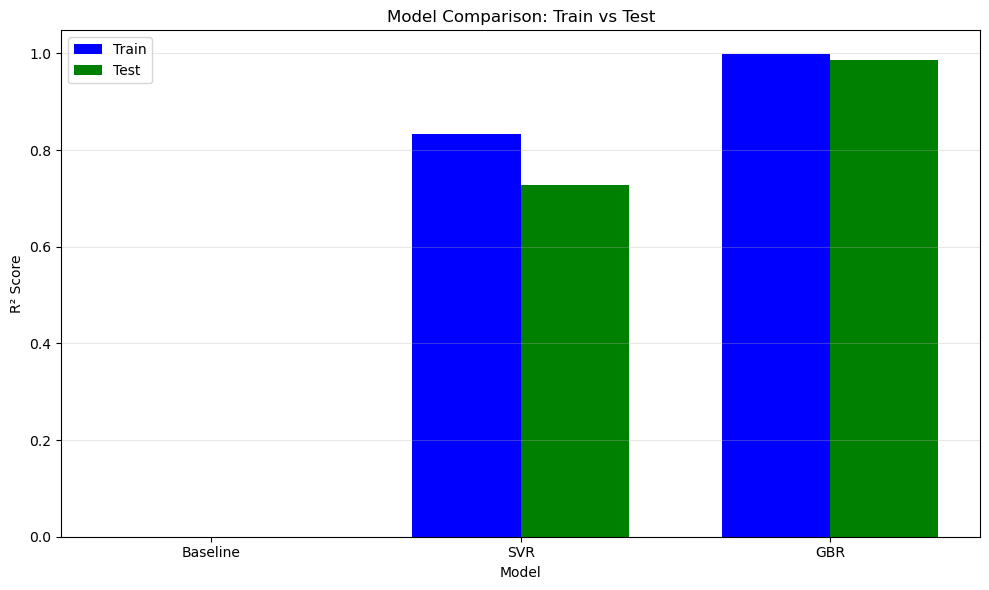

In [39]:
# ============================================================================
# MODEL COMPARISON
# ============================================================================
print("\n" + "=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Model': ['Baseline (Mean)', 'SVR', 'GBR'],
    'Train R²': [baseline_train_r2, svr_train_r2, gbr_train_r2],
    'Test R²': [baseline_test_r2, svr_test_r2, gbr_test_r2],
    'Test MSE': [baseline_test_mse, svr_test_mse, gbr_test_mse],
    'Test MAE': [baseline_test_mae, svr_test_mae, gbr_test_mae]
})

print("\n", comparison_df.to_string(index=False))

# Identify best model
best_model_idx = comparison_df['Test R²'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_test_r2 = comparison_df.loc[best_model_idx, 'Test R²']

print(f"\n Best Model: {best_model_name} with Test R² = {best_test_r2:.4f}!!!")

# checking for overfitting

models = ['Baseline', 'SVR', 'GBR']
train_r2 = [r2_score(y_train, y_train_baseline), 
            r2_score(y_train, y_train_svr), 
            r2_score(y_train, y_train_gbr)]
test_r2 = [r2_score(y_test, y_test_baseline), 
           r2_score(y_test, y_test_svr), 
           r2_score(y_test, y_test_gbr)]


fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(models))
width = 0.35

ax.bar([i - width/2 for i in x], train_r2, width, label='Train', color='blue')
ax.bar([i + width/2 for i in x], test_r2, width, label='Test', color='green')

ax.set_ylabel('R² Score')
ax.set_xlabel('Model')
ax.set_title('Model Comparison: Train vs Test')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("../report/figures/fig-2.1-overfitting-check.png", dpi=500)
plt.show()

### Modelling observations:

1. We can see that SVR model doest'nt perform the best and is showing signs of slight possible overfitting
2. We can also see that GBR model performs exceptional with both train and test performance being nearly identical, so there is negligible overfitting if at all 